# 0) 모듈 import

In [1]:
"""
pip install scikit-image    # LBP 특징 기술자를 포함한 라이브러리
pip install scikit-learn    # 기계학습용 라이브러리
"""
import cv2
import numpy as np
import glob
from skimage import feature
import matplotlib.pyplot as plt
%matplotlib inline

# 1) LBP의 조명 변화 불변 속성 확인

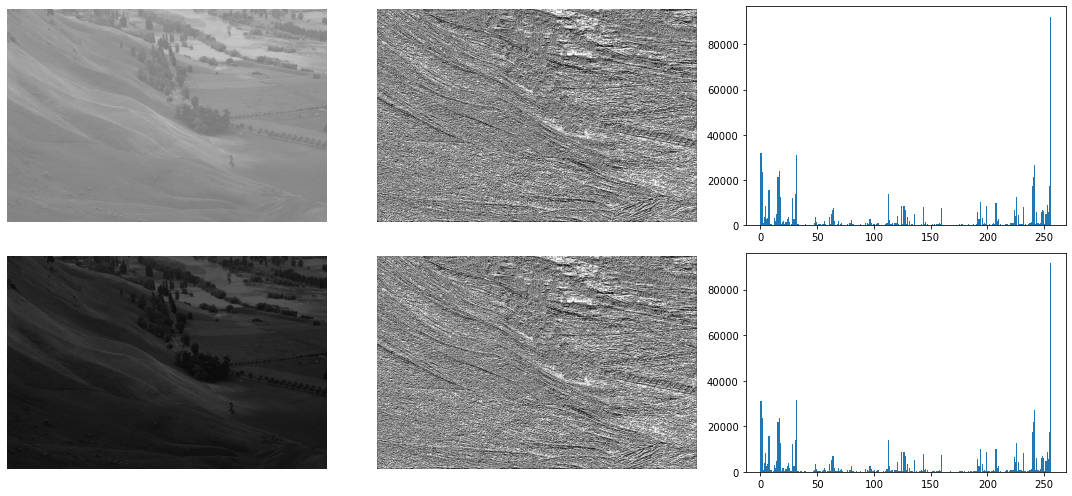

In [3]:
radius = 1
n_points = 8 * radius
method = 'default'

plt.figure(figsize=(15, 7))
   
for i, filepath in enumerate(['bright.jpg', 'dark.jpg']):
    #이렇게 하면 bright.jpg의 i,filepath같이 가져옴
    img = cv2.imread(filepath)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lbp = feature.local_binary_pattern(gray, n_points, radius, method)

    # 시각화
    plt.subplot(2, 3, (i*3)+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 3, (i*3)+2)
    plt.imshow(lbp, cmap='gray')
    plt.axis('off')
    
    plt.subplot(2, 3, (i*3)+3)
    plt.hist(lbp.ravel(), bins=256, range=[0, 256])

plt.tight_layout()
plt.show()
#조명상황이 다른데로 같은 lbp임(조명 불변)상대적인 명암차이만음 봄

# 2) 텍스처 특징을 이용한 얼굴 스푸핑 공격 탐지

## 2-0) 데이터 살펴보기
- real(생생함)
- print(잉크가 점으로 찍히기에 패턴 존재)
- replay(패턴 존재)

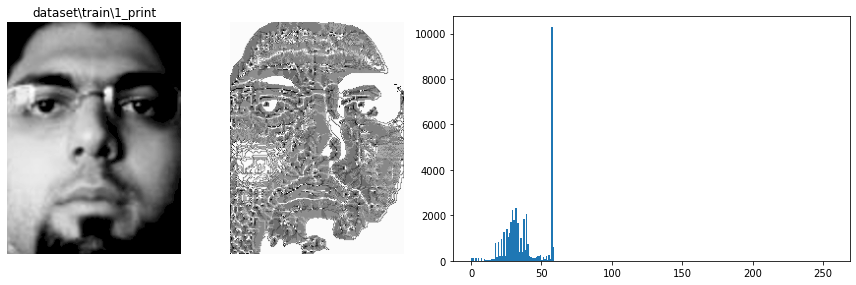

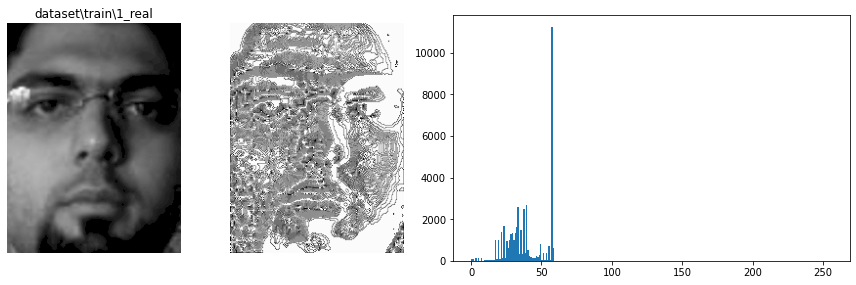

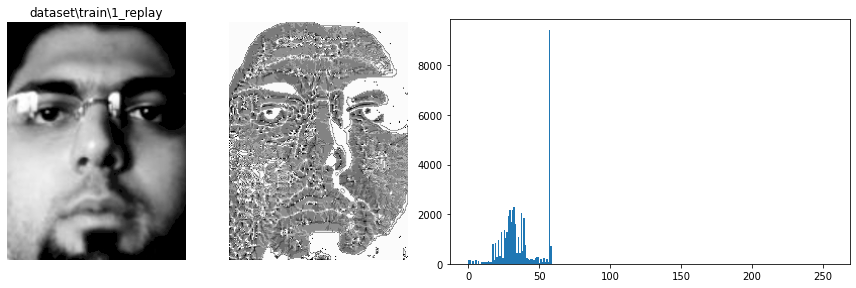

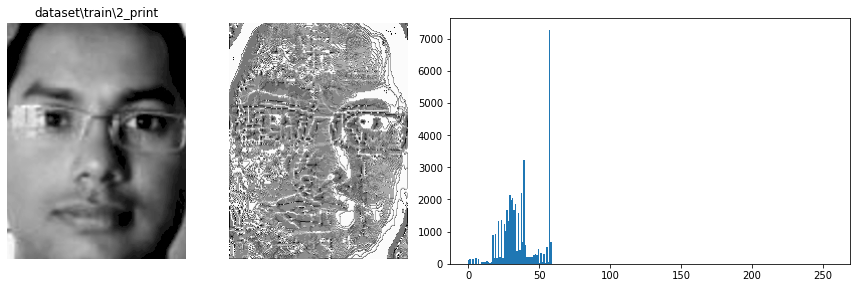

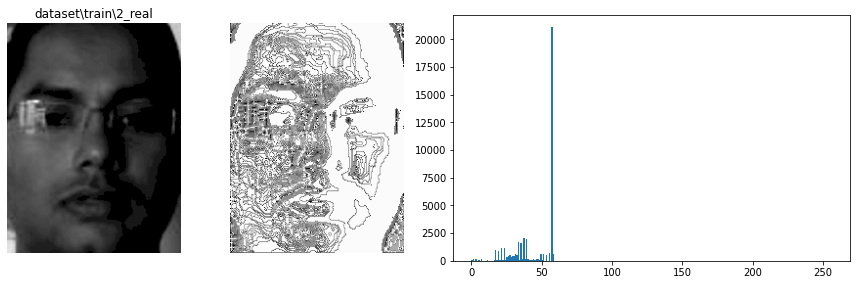

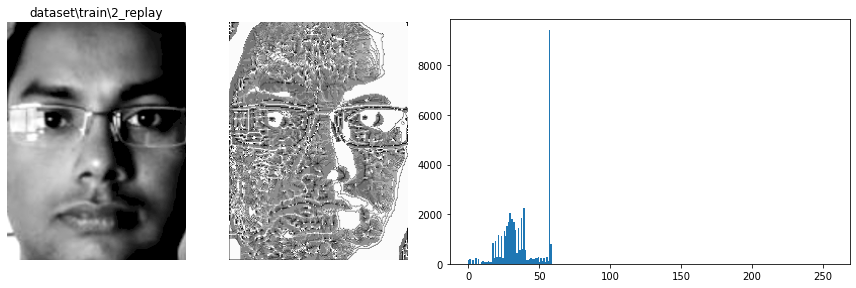

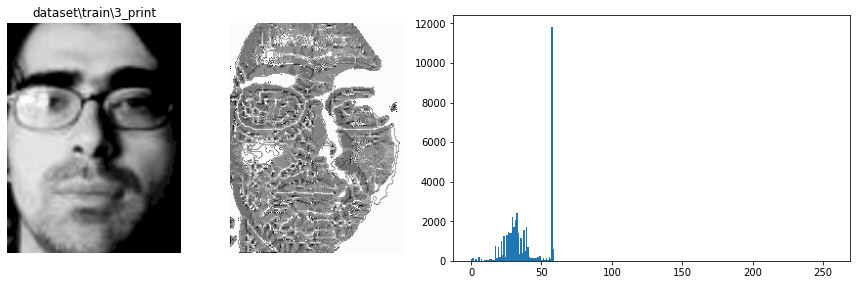

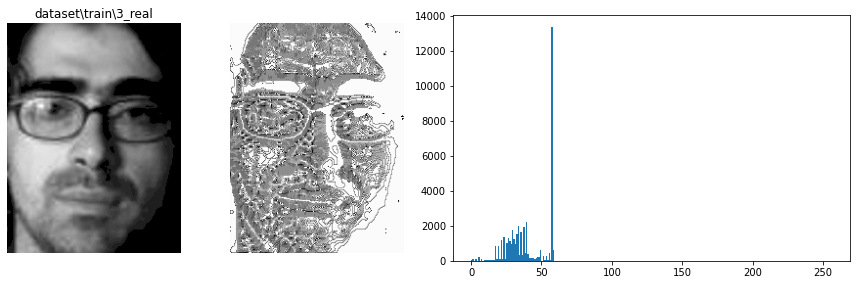

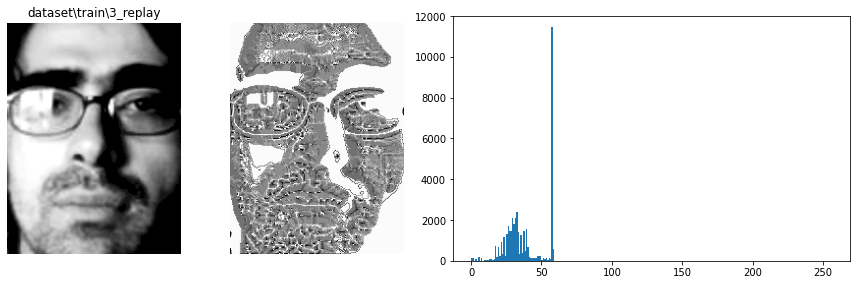

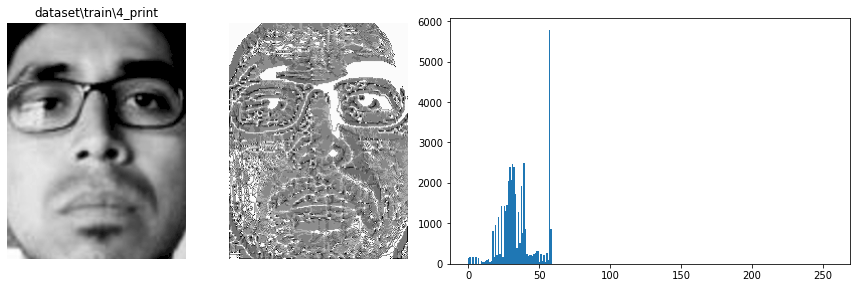

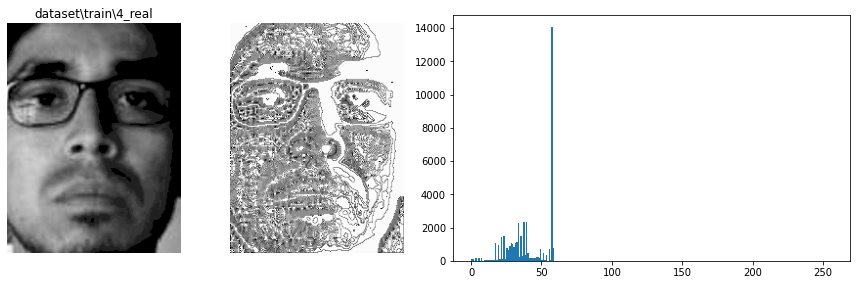

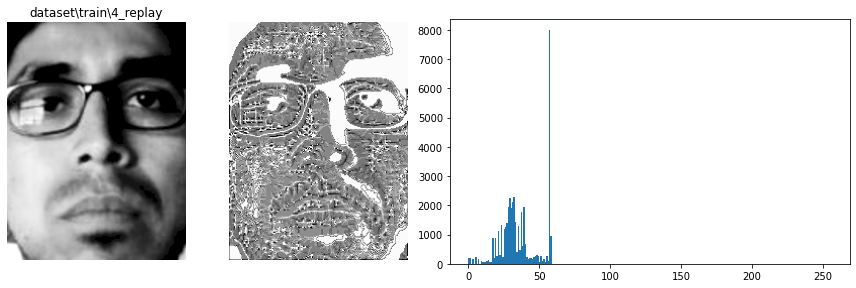

In [3]:
radius = 1
n_points = 8
method = 'nri_uniform'  # default / uniform / nri_uniform / ror
# https://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=lbp#local-binary-pattern

list_of_trainfiles = glob.glob(r'dataset\train\*.png')# train으로 모두 불러올수있음
#LBP 계산
for i, filepath in enumerate(list_of_trainfiles):
    gray = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    lbp = feature.local_binary_pattern(gray, n_points, radius, method)

    # 시각화
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(gray, cmap='gray')
    plt.axis('off')
    plt.title(filepath.split('.')[0])

    plt.subplot(1, 4, 2)
    plt.imshow(lbp, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, (3,4))
    plt.hist(lbp.ravel(), bins=256, range=[0, 256])
    
    plt.tight_layout()
    plt.show()

## 2-1) 기계학습을 위한 훈련데이터 준비
- 훈련데이터셋은 data와 label을 쌍(pair)으로 준비

In [4]:
import os

labels = []
data = []
for train_filepath in list_of_trainfiles:
    gray = cv2.imread(train_filepath, cv2.IMREAD_GRAYSCALE)
    lbp = feature.local_binary_pattern(gray, n_points, radius, method)
    hist, _ = np.histogram(lbp.ravel(), bins=n_points + 3, range=[0, n_points + 2])
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)  # 정규화
    data.append(hist)
    
    label = os.path.split(train_filepath)[-1][2:-4]
    labels.append(label)

In [5]:
labels

['print',
 'real',
 'replay',
 'print',
 'real',
 'replay',
 'print',
 'real',
 'replay',
 'print',
 'real',
 'replay']

## 2-2) 분류 모델 학습

In [6]:
from sklearn.svm import LinearSVC

model = LinearSVC(C=10, random_state=42)
model.fit(data, labels)

LinearSVC(C=10, random_state=42)

## 2-3) 성능 테스트
- 학습에 사용되지 않은 데이터(unseen)를 사용하여 테스트 수행

In [ ]:
list_of_testfiles = glob.glob(r'dataset\test\*.png')
for test_filepath in list_of_testfiles:
    img = cv2.imread(test_filepath)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lbp = feature.local_binary_pattern(gray, n_points, radius, method)
    hist, _ = np.histogram(lbp.ravel(), bins=n_points + 3, range=[0, n_points + 2])
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    
    # 학습된 분류 모델을 사용하여 테스트 이미지를 예측
    prediction = model.predict([hist])
    text_pred = 'Pred: %s' %  prediction[0]
    
    # 정답 레이블
    label = os.path.split(test_filepath)[-1][2:-4]
    text_label = 'Label: %s' %  label
    
    # 시각화
    cv2.putText(img, text_label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    cv2.putText(img, text_pred, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    cv2.imshow('test', img)
    cv2.waitKey()

cv2.destroyAllWindows()